### Importing libraries

In [ ]:
import open3d, os
import ctypes
from ctypes import *
from glob import glob

# Dataset

Since our dataset is quite big and it take several hours to preprocess it, we have uploaded the preprocessed dataset in a zip file. You can download it from [here](https://polimi365-my.sharepoint.com/:u:/g/personal/10978268_polimi_it/EdHy8Ij3NSpPmQh7nrogHWYB7OizNwVeL_f_Vt6rfnmYbA?e=LtZy1c).
Be sure to extract the zip file and upload the dataset to the working directory.

# Preprocessing
Skip this section if you have downloaded the preprocessed dataset and go directly to the training of neural network.

#### Data augmentation

First of all we need to augment the data in order to prevent overfitting.
First step is to rotate and scale (without changing the aspect ratio) the meshes.

In [ ]:
from utils import rotate_scale

files = glob("./dataset/train/input/quads/*")
for file in files:
    rotate_scale(file)


Secondly, we generate the trimesh objects from the quads meshes. This is done because the input of our network must be a trimesh object.

In [ ]:
from utils import generate_trimesh

files = glob("./dataset/train/input/quads/*")

for file in files:
    generate_trimesh(file)


Lastyl, we generate the output (true lables) of the network, which are the direction fields of the vertices.

In [ ]:
from utils import generate_output
import numpy as np

files_quads = glob("./dataset/train/input/quads/*")

for file in files_quads:
  file_name = os.path.basename(file)
  file_triangle = "./dataset/train/input/triangles/" + file_name

  orientation_fields = generate_output(file_triangle, file)
  orientation_fields_reshaped = orientation_fields.reshape(orientation_fields.shape[0], -1)


  # save the orientation fields in a txt file
  output_file = "./dataset/train/output/" + file_name
  np.savetxt(output_file, orientation_fields_reshaped)


  print("Orientation fields saved in: ", output_file)

## Loading mesh to retopologize

In [ ]:
# loading the shared library with C++
shared_library_path = glob(os.path.join("./build", "**/*.so"), recursive=True)
assert shared_library_path, "No shared library found, please build the shared library first (README.md for instructions)"
shared_library = ctypes.CDLL(shared_library_path[0])

file_path = "./dataset/train/input/triangles"
file_output_path = os.path.join(file_path, "..", "..", "output")

files_triangles = glob("./dataset/train/input/triangles/*")

for file_triangle in files_triangles:

    mesh = open3d.io.read_triangle_mesh(file_triangle)

    vertices = mesh.vertices
    triangles = mesh.triangles

    num_vertices = len(vertices)
    num_triangles = len(triangles)

    # create file input.txt
    file = open("input.txt", "w")

    # write vertices
    for i in range(len(vertices)):
        file.write(str(vertices[i][0]) + " " + str(vertices[i][1]) + " " + str(vertices[i][2]) + "\n")

    # write triangles
    for i in range(len(triangles)):
        file.write(str(triangles[i][0]) + " " + str(triangles[i][1]) + " " + str(triangles[i][2]) + "\n")


    file.close()

    k = 3 # neighborhood size

    file_output = os.path.join(file_output_path, os.path.basename(file_triangle))

    # get the complete url of the file
    file_output = os.path.abspath(file_output)

    # modify the basename concatenating _principal_directions
    file_output = file_output.replace(".obj", "_principal_directions.txt")

    output = create_string_buffer(file_output.encode('utf-8'),size=100)
    shared_library.crest_lines(num_vertices, num_triangles, k, output)

# Learning

General settings

In [1]:
import torch
import os
from pathlib import Path

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA...")
else:
    device = torch.device('cpu')
    print("Using CPU...")

dtype = torch.float32

# Problem/dataset things
n_class = 4

# Model 
input_features = 'hks'      # 'hks' or 'xyz'
k_eig = 128

# Training settings
train = True                # Whether to train the model
n_epoch = 10000
lr = 1e-4
decay_every = 50
decay_rate = 0.5
augment_random_rotate = (input_features == 'xyz')

# Important paths
base_path = Path(os.getcwd())
op_cache_dir = os.path.join(base_path, "neural_network", "data", "op_cache")
dataset_path = os.path.join(base_path, "dataset")
dataset_path = os.path.normpath(dataset_path)

Using CPU...


Loading data

In [2]:
from torch.utils.data import DataLoader
from neural_network.dataset import MeshDataset

# Load the test dataset
test_dataset = MeshDataset(dataset_path, train=False, k_eig=k_eig, use_cache=False, op_cache_dir=op_cache_dir)
test_loader = DataLoader(test_dataset, batch_size=None)

# Load the train dataset
if train:
    train_dataset = MeshDataset(dataset_path, train=True, k_eig=k_eig, use_cache=False, op_cache_dir=op_cache_dir)
    train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)

loading 1 meshes
loading mesh /Users/matteobalice/Desktop/retopology/dataset/train/input/triangles/female_0001.obj
get_all_operators() processing 0 / 1 0.000%
loading 1 meshes
loading mesh /Users/matteobalice/Desktop/retopology/dataset/train/input/triangles/female_0001.obj


/Users/matteobalice/Desktop/retopology/neural_network/diffusion_net/network_utils.py:55: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(shape)).coalesce()


get_all_operators() processing 0 / 1 0.000%


Model settings

In [3]:
from neural_network import diffusion_net

# === Create the model

C_in={'xyz':3, 'hks':12}[input_features] # Dimension of input features

model = diffusion_net.layers.DiffusionNet(C_in=C_in,
                                          C_out=n_class,
                                          C_width=256, 
                                          N_block=6,
                                          outputs_at='vertices', 
                                          dropout=False)

if os.path.exists('saved_model.pth'):
    model.load_state_dict(torch.load('saved_model.pth', map_location=device))
    print('Loaded model from: saved_model.pth')

model = model.to(device)

# === Optimize

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

Training

In [4]:
from neural_network.neural_network_management import train_epoch, test

if train:
    print("Training...")

    for epoch in range(n_epoch):
        if epoch % 100 == 0 and epoch > 0:
            torch.save(model.state_dict(), 'saved_model.pth')
            print('Model saved in: saved_model.pth')
        train_loss = train_epoch(epoch, decay_every, decay_rate, optimizer, model, train_loader, device, augment_random_rotate, input_features)

        if epoch % 20 == 0 and epoch > 0:
            test_loss = test(model, test_loader, device, input_features)
            print("Epoch {} - Train overall: {:06.3f}  Test overall: {:06.3f}".format(epoch, train_loss, test_loss))
        else:
            print("Epoch {} - Train overall: {:06.3f}".format(epoch, train_loss))


test_loss, theta_loss, phi_loss = test()
print("Overall test loss: {:06.3f}%".format(test_loss))

Training...


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch 0 - Train overall: 00.447


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 1 - Train overall: 00.464


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Epoch 2 - Train overall: 00.418


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 3 - Train overall: 00.423


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 4 - Train overall: 00.411


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Epoch 5 - Train overall: 00.399


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 6 - Train overall: 00.403


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 7 - Train overall: 00.404


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 8 - Train overall: 00.395


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 9 - Train overall: 00.388


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 10 - Train overall: 00.386


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 11 - Train overall: 00.382


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 12 - Train overall: 00.378


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 13 - Train overall: 00.378


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Epoch 14 - Train overall: 00.377


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 15 - Train overall: 00.372


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 16 - Train overall: 00.370


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Epoch 17 - Train overall: 00.371


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 18 - Train overall: 00.367


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 19 - Train overall: 00.363


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch 20 - Train overall: 00.361  Test overall: 00.240


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch 21 - Train overall: 00.360


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 22 - Train overall: 00.358


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Epoch 23 - Train overall: 00.355


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 24 - Train overall: 00.352


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 25 - Train overall: 00.350


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 26 - Train overall: 00.348


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 27 - Train overall: 00.344


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 28 - Train overall: 00.341


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 29 - Train overall: 00.339


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 30 - Train overall: 00.335


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 31 - Train overall: 00.332


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 32 - Train overall: 00.329


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 33 - Train overall: 00.325


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 34 - Train overall: 00.322


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 35 - Train overall: 00.318


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch 36 - Train overall: 00.315


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 37 - Train overall: 00.311


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 38 - Train overall: 00.307


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 39 - Train overall: 00.303


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 40 - Train overall: 00.299  Test overall: 00.194


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 41 - Train overall: 00.295


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 42 - Train overall: 00.292


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 43 - Train overall: 00.290


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 44 - Train overall: 00.289


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Epoch 45 - Train overall: 00.284


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Epoch 46 - Train overall: 00.277


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 47 - Train overall: 00.276


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 48 - Train overall: 00.276


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 49 - Train overall: 00.269


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 50 - Train overall: 00.265


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 51 - Train overall: 00.265


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 52 - Train overall: 00.261


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 53 - Train overall: 00.257


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 54 - Train overall: 00.254


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 55 - Train overall: 00.253


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 56 - Train overall: 00.252


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 57 - Train overall: 00.248


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 58 - Train overall: 00.245


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 59 - Train overall: 00.241


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch 60 - Train overall: 00.239  Test overall: 00.154


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 61 - Train overall: 00.238


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 62 - Train overall: 00.238


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Epoch 63 - Train overall: 00.242


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Epoch 64 - Train overall: 00.237


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 65 - Train overall: 00.230


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Epoch 66 - Train overall: 00.227


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 67 - Train overall: 00.229


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Epoch 68 - Train overall: 00.229


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 69 - Train overall: 00.222


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 70 - Train overall: 00.219


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 71 - Train overall: 00.221


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 72 - Train overall: 00.220


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 73 - Train overall: 00.215


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 74 - Train overall: 00.213


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 75 - Train overall: 00.213


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 76 - Train overall: 00.212


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 77 - Train overall: 00.209


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 78 - Train overall: 00.208


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 79 - Train overall: 00.207


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch 80 - Train overall: 00.205  Test overall: 00.128


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 81 - Train overall: 00.202


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 82 - Train overall: 00.201


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 83 - Train overall: 00.201


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 84 - Train overall: 00.199


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 85 - Train overall: 00.197


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 86 - Train overall: 00.195


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 87 - Train overall: 00.194


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 88 - Train overall: 00.194


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 89 - Train overall: 00.196


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 90 - Train overall: 00.206


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 91 - Train overall: 00.219


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 92 - Train overall: 00.208


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 93 - Train overall: 00.192


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 94 - Train overall: 00.204


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 95 - Train overall: 00.200


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 96 - Train overall: 00.189


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 97 - Train overall: 00.200


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 98 - Train overall: 00.189


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 99 - Train overall: 00.190
Model saved in: saved_model.pth


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch 100 - Train overall: 00.192  Test overall: 00.115


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 101 - Train overall: 00.183


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 102 - Train overall: 00.189


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 103 - Train overall: 00.182


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 104 - Train overall: 00.183


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 105 - Train overall: 00.184


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 106 - Train overall: 00.178


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 107 - Train overall: 00.182


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 108 - Train overall: 00.178


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 109 - Train overall: 00.177


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 110 - Train overall: 00.178


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Epoch 111 - Train overall: 00.174


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Epoch 112 - Train overall: 00.176


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 113 - Train overall: 00.174


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 114 - Train overall: 00.171


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 115 - Train overall: 00.173


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 116 - Train overall: 00.171


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 117 - Train overall: 00.169


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 118 - Train overall: 00.171


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 119 - Train overall: 00.168


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch 120 - Train overall: 00.167  Test overall: 00.104


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 121 - Train overall: 00.168


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 122 - Train overall: 00.166


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 123 - Train overall: 00.165


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 124 - Train overall: 00.165


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 125 - Train overall: 00.164


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch 126 - Train overall: 00.162


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 127 - Train overall: 00.162


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 128 - Train overall: 00.162


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 129 - Train overall: 00.161


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 130 - Train overall: 00.160


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 131 - Train overall: 00.162


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 132 - Train overall: 00.165


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Epoch 133 - Train overall: 00.167


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Epoch 134 - Train overall: 00.163


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 135 - Train overall: 00.159


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 136 - Train overall: 00.158


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 137 - Train overall: 00.159


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Epoch 138 - Train overall: 00.159


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 139 - Train overall: 00.156


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 140 - Train overall: 00.155  Test overall: 00.096


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 141 - Train overall: 00.156


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch 142 - Train overall: 00.155


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 143 - Train overall: 00.153


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Epoch 144 - Train overall: 00.152


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 145 - Train overall: 00.152


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 146 - Train overall: 00.153


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 147 - Train overall: 00.151


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 148 - Train overall: 00.149


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 149 - Train overall: 00.149


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 150 - Train overall: 00.151


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 151 - Train overall: 00.154


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 152 - Train overall: 00.160


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 153 - Train overall: 00.164


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 154 - Train overall: 00.160


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 155 - Train overall: 00.152


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 156 - Train overall: 00.149


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 157 - Train overall: 00.152


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 158 - Train overall: 00.153


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 159 - Train overall: 00.149


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch 160 - Train overall: 00.145  Test overall: 00.090


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 161 - Train overall: 00.147


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Epoch 162 - Train overall: 00.149


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch 163 - Train overall: 00.145


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 164 - Train overall: 00.142


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Epoch 165 - Train overall: 00.144


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Epoch 166 - Train overall: 00.145


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 167 - Train overall: 00.142


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 168 - Train overall: 00.140


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 169 - Train overall: 00.142


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 170 - Train overall: 00.143


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch 171 - Train overall: 00.144


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 172 - Train overall: 00.147


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 173 - Train overall: 00.153


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 174 - Train overall: 00.155


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 175 - Train overall: 00.141


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 176 - Train overall: 00.138


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 177 - Train overall: 00.144


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 178 - Train overall: 00.144


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 179 - Train overall: 00.139


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch 180 - Train overall: 00.138  Test overall: 00.086


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 181 - Train overall: 00.140


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluation

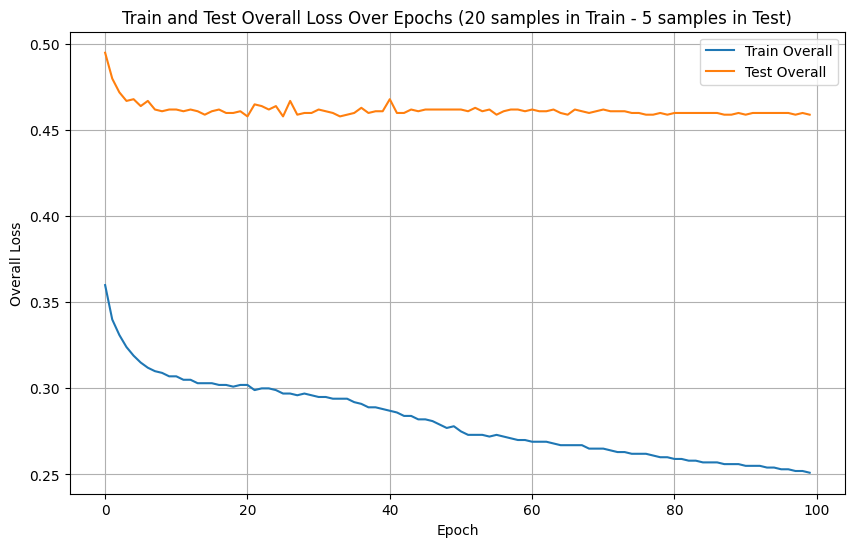

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the training and testing process
epochs = np.arange(100)
train_overall = [
    0.36, 0.34, 0.331, 0.324, 0.319, 0.315, 0.312, 0.31, 0.309, 0.307,
    0.307, 0.305, 0.305, 0.303, 0.303, 0.303, 0.302, 0.302, 0.301, 0.302,
    0.302, 0.299, 0.3, 0.3, 0.299, 0.297, 0.297, 0.296, 0.297, 0.296,
    0.295, 0.295, 0.294, 0.294, 0.294, 0.292, 0.291, 0.289, 0.289, 0.288,
    0.287, 0.286, 0.284, 0.284, 0.282, 0.282, 0.281, 0.279, 0.277, 0.278,
    0.275, 0.273, 0.273, 0.273, 0.272, 0.273, 0.272, 0.271, 0.27, 0.27,
    0.269, 0.269, 0.269, 0.268, 0.267, 0.267, 0.267, 0.267, 0.265, 0.265,
    0.265, 0.264, 0.263, 0.263, 0.262, 0.262, 0.262, 0.261, 0.26, 0.26,
    0.259, 0.259, 0.258, 0.258, 0.257, 0.257, 0.257, 0.256, 0.256, 0.256,
    0.255, 0.255, 0.255, 0.254, 0.254, 0.253, 0.253, 0.252, 0.252, 0.251
]

test_overall = [
    0.495, 0.48, 0.472, 0.467, 0.468, 0.464, 0.467, 0.462, 0.461, 0.462,
    0.462, 0.461, 0.462, 0.461, 0.459, 0.461, 0.462, 0.46, 0.46, 0.461,
    0.458, 0.465, 0.464, 0.462, 0.464, 0.458, 0.467, 0.459, 0.46, 0.46,
    0.462, 0.461, 0.46, 0.458, 0.459, 0.46, 0.463, 0.46, 0.461, 0.461,
    0.468, 0.46, 0.46, 0.462, 0.461, 0.462, 0.462, 0.462, 0.462, 0.462,
    0.462, 0.461, 0.463, 0.461, 0.462, 0.459, 0.461, 0.462, 0.462, 0.461,
    0.462, 0.461, 0.461, 0.462, 0.46, 0.459, 0.462, 0.461, 0.46, 0.461,
    0.462, 0.461, 0.461, 0.461, 0.46, 0.46, 0.459, 0.459, 0.46, 0.459,
    0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.459, 0.459, 0.46,
    0.459, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.459, 0.46, 0.459
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (20 samples in Train - 5 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

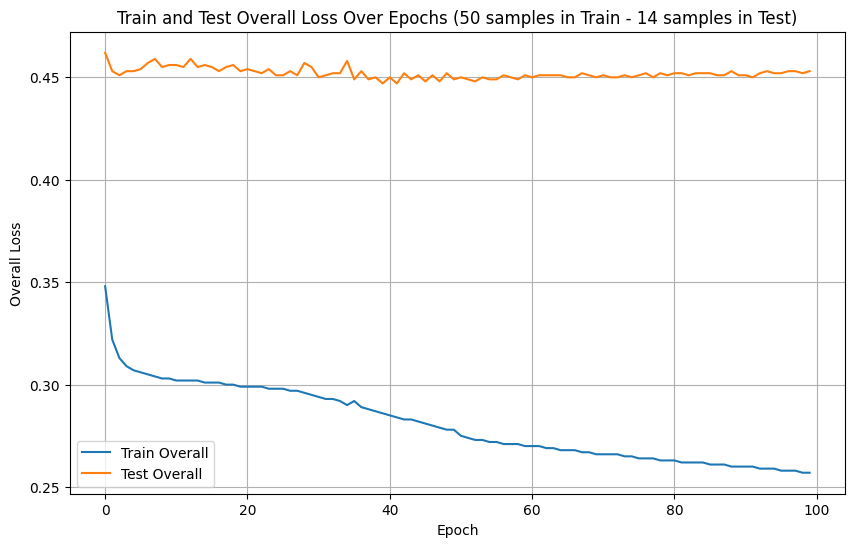

In [11]:
train_overall = [
    0.348, 0.322, 0.313, 0.309, 0.307, 0.306, 0.305, 0.304, 0.303, 0.303,
    0.302, 0.302, 0.302, 0.302, 0.301, 0.301, 0.301, 0.3, 0.3, 0.299,
    0.299, 0.299, 0.299, 0.298, 0.298, 0.298, 0.297, 0.297, 0.296, 0.295,
    0.294, 0.293, 0.293, 0.292, 0.29, 0.292, 0.289, 0.288, 0.287, 0.286,
    0.285, 0.284, 0.283, 0.283, 0.282, 0.281, 0.28, 0.279, 0.278, 0.278,
    0.275, 0.274, 0.273, 0.273, 0.272, 0.272, 0.271, 0.271, 0.271, 0.27,
    0.27, 0.27, 0.269, 0.269, 0.268, 0.268, 0.268, 0.267, 0.267, 0.266,
    0.266, 0.266, 0.266, 0.265, 0.265, 0.264, 0.264, 0.264, 0.263, 0.263,
    0.263, 0.262, 0.262, 0.262, 0.262, 0.261, 0.261, 0.261, 0.26, 0.26,
    0.26, 0.26, 0.259, 0.259, 0.259, 0.258, 0.258, 0.258, 0.257, 0.257
]

test_overall = [
    0.462, 0.453, 0.451, 0.453, 0.453, 0.454, 0.457, 0.459, 0.455, 0.456,
    0.456, 0.455, 0.459, 0.455, 0.456, 0.455, 0.453, 0.455, 0.456, 0.453,
    0.454, 0.453, 0.452, 0.454, 0.451, 0.451, 0.453, 0.451, 0.457, 0.455,
    0.45, 0.451, 0.452, 0.452, 0.458, 0.449, 0.453, 0.449, 0.45, 0.447,
    0.45, 0.447, 0.452, 0.449, 0.451, 0.448, 0.451, 0.448, 0.452, 0.449,
    0.45, 0.449, 0.448, 0.45, 0.449, 0.449, 0.451, 0.45, 0.449, 0.451,
    0.45, 0.451, 0.451, 0.451, 0.451, 0.45, 0.45, 0.452, 0.451, 0.45,
    0.451, 0.45, 0.45, 0.451, 0.45, 0.451, 0.452, 0.45, 0.452, 0.451,
    0.452, 0.452, 0.451, 0.452, 0.452, 0.452, 0.451, 0.451, 0.453, 0.451,
    0.451, 0.45, 0.452, 0.453, 0.452, 0.452, 0.453, 0.453, 0.452, 0.453
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (50 samples in Train - 14 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

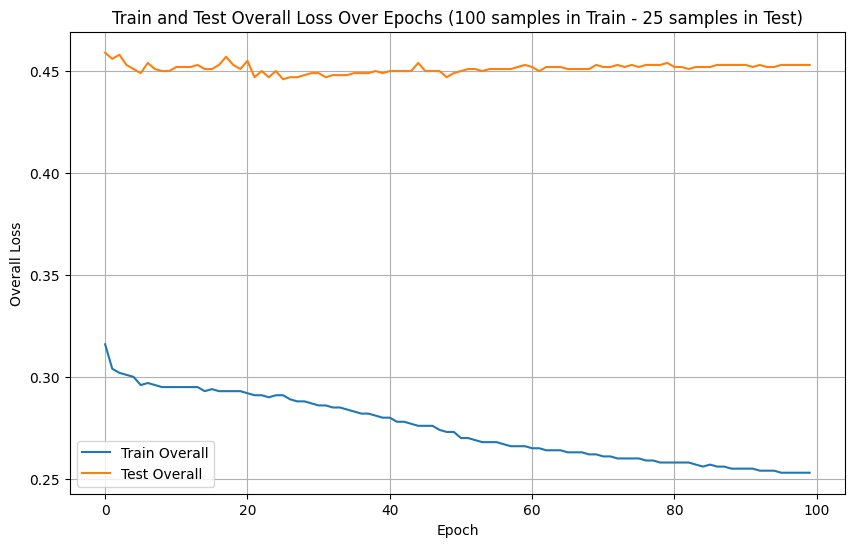

In [13]:
train_overall = [
    0.316, 0.304, 0.302, 0.301, 0.3, 0.296, 0.297, 0.296, 0.295, 0.295,
    0.295, 0.295, 0.295, 0.295, 0.293, 0.294, 0.293, 0.293, 0.293, 0.293,
    0.292, 0.291, 0.291, 0.29, 0.291, 0.291, 0.289, 0.288, 0.288, 0.287,
    0.286, 0.286, 0.285, 0.285, 0.284, 0.283, 0.282, 0.282, 0.281, 0.28,
    0.28, 0.278, 0.278, 0.277, 0.276, 0.276, 0.276, 0.274, 0.273, 0.273,
    0.27, 0.27, 0.269, 0.268, 0.268, 0.268, 0.267, 0.266, 0.266, 0.266,
    0.265, 0.265, 0.264, 0.264, 0.264, 0.263, 0.263, 0.263, 0.262, 0.262,
    0.261, 0.261, 0.26, 0.26, 0.26, 0.26, 0.259, 0.259, 0.258, 0.258,
    0.258, 0.258, 0.258, 0.257, 0.256, 0.257, 0.256, 0.256, 0.255, 0.255,
    0.255, 0.255, 0.254, 0.254, 0.254, 0.253, 0.253, 0.253, 0.253, 0.253
]

test_overall = [
    0.459, 0.456, 0.458, 0.453, 0.451, 0.449, 0.454, 0.451, 0.45, 0.45,
    0.452, 0.452, 0.452, 0.453, 0.451, 0.451, 0.453, 0.457, 0.453, 0.451,
    0.455, 0.447, 0.45, 0.447, 0.45, 0.446, 0.447, 0.447, 0.448, 0.449,
    0.449, 0.447, 0.448, 0.448, 0.448, 0.449, 0.449, 0.449, 0.45, 0.449,
    0.45, 0.45, 0.45, 0.45, 0.454, 0.45, 0.45, 0.45, 0.447, 0.449,
    0.45, 0.451, 0.451, 0.45, 0.451, 0.451, 0.451, 0.451, 0.452, 0.453,
    0.452, 0.45, 0.452, 0.452, 0.452, 0.451, 0.451, 0.451, 0.451, 0.453,
    0.452, 0.452, 0.453, 0.452, 0.453, 0.452, 0.453, 0.453, 0.453, 0.454,
    0.452, 0.452, 0.451, 0.452, 0.452, 0.452, 0.453, 0.453, 0.453, 0.453,
    0.453, 0.452, 0.453, 0.452, 0.452, 0.453, 0.453, 0.453, 0.453, 0.453
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (100 samples in Train - 25 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

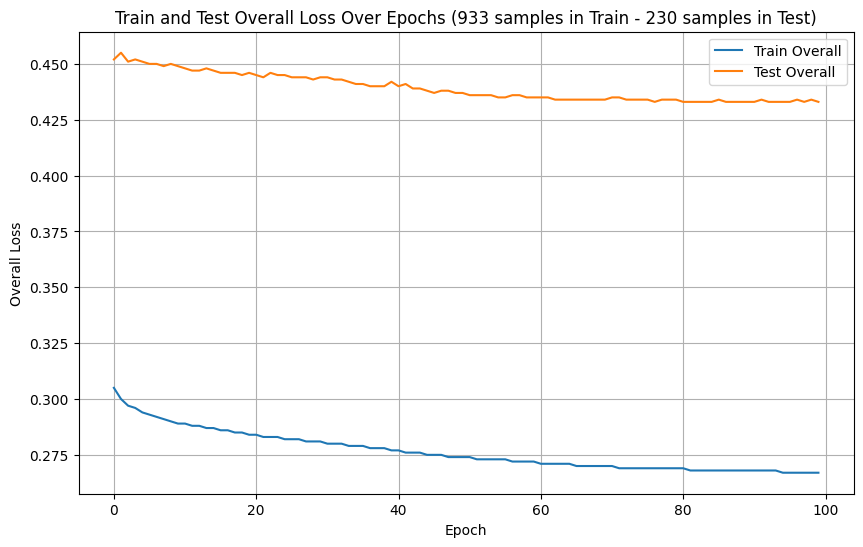

In [14]:
train_overall = [
    0.305, 0.300, 0.297, 0.296, 0.294, 0.293, 0.292, 0.291, 0.290, 0.289,
    0.289, 0.288, 0.288, 0.287, 0.287, 0.286, 0.286, 0.285, 0.285, 0.284, 
    0.284, 0.283, 0.283, 0.283, 0.282, 0.282, 0.282, 0.281, 0.281, 0.281, 
    0.280, 0.280, 0.280, 0.279, 0.279, 0.279, 0.278, 0.278, 0.278, 0.277, 
    0.277, 0.276, 0.276, 0.276, 0.275, 0.275, 0.275, 0.274, 0.274, 0.274, 
    0.274, 0.273, 0.273, 0.273, 0.273, 0.273, 0.272, 0.272, 0.272, 0.272, 
    0.271, 0.271, 0.271, 0.271, 0.271, 0.270, 0.270, 0.270, 0.270, 0.270, 
    0.270, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 
    0.269, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 
    0.268, 0.268, 0.268, 0.268, 0.267, 0.267, 0.267, 0.267, 0.267, 0.267,
]

test_overall = [
    0.452, 0.455, 0.451, 0.452, 0.451, 0.450, 0.450, 0.449, 0.450, 0.449,
    0.448, 0.447, 0.447, 0.448, 0.447, 0.446, 0.446, 0.446, 0.445, 0.446,
    0.445, 0.444, 0.446, 0.445, 0.445, 0.444, 0.444, 0.444, 0.443, 0.444,
    0.444, 0.443, 0.443, 0.442, 0.441, 0.441, 0.440, 0.440, 0.440, 0.442,
    0.440, 0.441, 0.439, 0.439, 0.438, 0.437, 0.438, 0.438, 0.437, 0.437,
    0.436, 0.436, 0.436, 0.436, 0.435, 0.435, 0.436, 0.436, 0.435, 0.435,
    0.435, 0.435, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434,
    0.435, 0.435, 0.434, 0.434, 0.434, 0.434, 0.433, 0.434, 0.434, 0.434,
    0.433, 0.433, 0.433, 0.433, 0.433, 0.434, 0.433, 0.433, 0.433, 0.433,
    0.433, 0.434, 0.433, 0.433, 0.433, 0.433, 0.434, 0.433, 0.434, 0.433
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (933 samples in Train - 230 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import plotly.express as px
import pandas as pd
from math import sin, cos


# convert from spherical to cartesian coordinates
def convert_spherical_to_cartesian(r, theta, phi):
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)
    return x,y,z
 
x1,y1,z1 = convert_spherical_to_cartesian(1, 6.947085261997695271e-01, 2.261645934151683690e-01)
x3,y3,z3 = convert_spherical_to_cartesian(1, 2.342013730646936853e+00, -4.335735359697641678e-01)

x2,y2,z2 = convert_spherical_to_cartesian(1, -2.3883, -1.7676)
x4,y4,z4 = convert_spherical_to_cartesian(1, 2.3762,  1.3087)


# Dati del vettore tridimensionale
data = {
    'x': [0, x1, 0, x2, 0, x3, 0, x4],  # Coordinata x (origine e punta del vettore)
    'y': [0, y1, 0, y2, 0, y3, 0, y4],  # Coordinata y (origine e punta del vettore)
    'z': [0, z1, 0, z2, 0, z3, 0, z4]   # Coordinata z (origine e punta del vettore)
}

# Creazione di un DataFrame
df = pd.DataFrame(data)

# Creazione del grafico 3D
fig = px.scatter_3d(df, x='x', y='y', z='z')

# Aggiunta del vettore come una linea
fig.add_scatter3d(x=[0, x1], y=[0, y1], z=[0, z1], mode='lines', line=dict(color='red', width=5))
fig.add_scatter3d(x=[0, x2], y=[0, y2], z=[0, z2], mode='lines', line=dict(color='blue', width=5))
fig.add_scatter3d(x=[0, x3], y=[0, y3], z=[0, z3], mode='lines', line=dict(color='green', width=5))
fig.add_scatter3d(x=[0, x4], y=[0, y4], z=[0, z4], mode='lines', line=dict(color='yellow', width=5))


# Mostrare il grafico
fig.show()